In [170]:
from tqdm.notebook import tqdm
import pickle
from collections import defaultdict
import numpy as np
from numpy import log, log1p, exp, sqrt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, ttest_1samp

ANN_FACTOR = 5

# Data Load, Statistics

In [171]:
# maybe need to include more than just common stocks... too little data?
with open('./data/stocks.pkl', 'rb') as f:
    stocks = pickle.load(f)

with open('./data/market.pkl', 'rb') as f:
    market = pickle.load(f)

In [172]:
# Calculate the returns within the bounds for listed and delisted stocks

# # Filter for listed stocks
# listed_stocks = stocks[(stocks['date'] >= lb) & (stocks['date'] < ub)]

# # Filter for delisted stocks (delisted within six months after the upper bound)
# delisted_stocks = stocks[(stocks['ending'] >= ub) & (stocks['ending'] < db)]
most_recent_date = stocks['ending'].max()

# Listed stocks are those that have an ending date after the most recent date in the dataset??
listed_stocks = stocks[stocks['ending'] >= most_recent_date]

# Delisted stocks are those that have an ending date before the most recent date??
delisted_stocks = stocks[stocks['ending'] < most_recent_date]

# Ensure that we are only considering unique tickers for the listed and delisted stocks
listed_tickers = listed_stocks['ticker'].unique()
delisted_tickers = delisted_stocks['ticker'].unique()

listed_stocks = stocks[stocks['ticker'].isin(listed_tickers)]
delisted_stocks = stocks[stocks['ticker'].isin(delisted_tickers)]


# Calculate the descriptive statistics for each category
def calculate_statistics(df, return_type):
    if "ticker" in df.columns:
        no_ind = len(df.ticker.unique())
    else:
        no_ind = 1
    avg_return = round(df[return_type].mean()*100, 3)
    max_return = round(df[return_type].max()*100, 1)
    min_return = round(df[return_type].min()*100, 1)
    
    std_dev = round(df[return_type].std()*100, 3)

    skewness = round(skew(df[return_type]), 2)
    
    kurt = round(kurtosis(df[return_type]), 2)
    
    return (avg_return, max_return, min_return, std_dev, skewness, kurt, no_ind)

# Calculate stats for listed, delisted, and all stocks
stats_listed = calculate_statistics(listed_stocks, "ret")
stats_delisted = calculate_statistics(delisted_stocks, "ret")
stats_all = calculate_statistics(stocks, "ret")

# Calculate stats for the market
stats_market = calculate_statistics(market, "sprtrn")

# Create a dictionary to hold the data
data = {
    'Category': ['Listed Stocks', 'Delisted Stocks', 'All Stocks', 'Market'],
    'Number of Indices': [stats_listed[6], stats_delisted[6], stats_all[6], stats_market[6]],
    'Avg. Return % (Max/Min)': [f"{stats_listed[0]} ({stats_listed[1]} / {stats_listed[2]})",
                                 f"{stats_delisted[0]} ({stats_delisted[1]} / {stats_delisted[2]})",
                                 f"{stats_all[0]} ({stats_all[1]} / {stats_all[2]})",
                                 f"{stats_market[0]} ({stats_market[1]} / {stats_market[2]})"],
    'Avg. SD %':                [f"{stats_listed[3]}",
                             f"{stats_delisted[3]}",
                             f"{stats_all[3]}",
                             f"{stats_market[3]}"],
    'Avg. Skewness':            [f"{stats_listed[4]}",
                                 f"{stats_delisted[4]}",
                                 f"{stats_all[4]}",
                                 f"{stats_market[4]}"],
    'Avg. Kurtosis':            [f"{stats_listed[5]}",
                                 f"{stats_delisted[6]}",
                                 f"{stats_all[5]}",
                                 f"{stats_market[5]}"]
}

# Convert dictionary to DataFrame
descriptive_stats_table = pd.DataFrame(data)

# Print the table to check
descriptive_stats_table


,Category,Number of Indices,Avg. Return % (Max/Min),Avg. SD %,Avg. Skewness,Avg. Kurtosis
0,Listed Stocks,505,0.317 (167.8 / -96.2),4.723,1.09,31.96
1,Delisted Stocks,454,0.229 (161.7 / -99.8),5.759,0.83,454
2,All Stocks,930,0.289 (167.8 / -99.8),5.076,1.01,32.57
3,Market,1,0.181 (15.3 / -18.2),2.29,-0.21,5.28


# Beta Computation, Portfolio Construction

In [173]:
# First, stocks that had not been listed for the entire two-year period were excluded due to their short history. 
# Second, stocks that were delisted within the next six-month period were also excluded.

lb = pd.to_datetime('2003-01-01') # window lower bound
two_yr = pd.DateOffset(years=2)
ub = lb + two_yr # window upper bound
six_mo = pd.DateOffset(months=6)
db = ub + six_mo # delisting bound

quant_cutoffs = (0, 0.2, 0.4, 0.6, 0.8, 1)

sp500_up_dates = market[market.sprtrn > 0].index
sp500_down_dates = market[market.sprtrn <= 0].index

dates = list()
# 3 types of beta, 5 quantiles => 15 time-series of annualized returns
history = [
        [ [],[],[],[],[] ],
        [ [],[],[],[],[] ],
        [ [],[],[],[],[] ]
    ]

while db <= stocks.date.max():
    # paper's conditions: 2 yr window size, sliding in 6 mo. increments, delisting inclusion conditions
    m1 = (stocks.date >= lb) & (stocks.date < ub) & (stocks.start < lb) & (stocks.ending >= db)
    
    m2 = (stocks.date >= ub) & (stocks.date < db)
    
    ### BETA ESTIMATION (3 TYPES) ###
    # x is design matrix of market return having shape n_obs x 2
    # y is matrix of stock returns having shape n_obs x n_stocks
    # np.linalg.inv((x.T).dot(x)).dot(x.T).dot(y) -> get \beta_1
    y_train = stocks[m1].pivot(index='date', columns='permno', values='ret').dropna(how='any', axis=1)
    y_test = stocks[m2].pivot(index='date', columns='permno', values='ret').dropna(how='any', axis=1)
    
    shared_names = list(set(y_train.columns).intersection(set(y_test.columns))) # companies must match for train and test (portfolio return)
    y_train, y_test = y_train[shared_names], y_test[shared_names]

    shared_dates = (y_train.index).intersection(market.index, sort=True) # dates must match for train and SP500 (regression)
    up_dates = shared_dates.intersection(sp500_up_dates, sort=True)
    down_dates = shared_dates.intersection(sp500_down_dates, sort=True)

    for i, dt in enumerate((shared_dates, up_dates, down_dates)):
        x_train = np.ones((len(dt), 2))
        x_train[:, 1] = market.loc[dt, 'sprtrn']
        
        # high-IQ OLS moment
        beta = np.linalg.inv((x_train.T).dot(x_train)).dot(x_train.T).dot(y_train.loc[dt, :])[1, :]

        # need to compute realized return over NEXT six mo
        # portfolio construction via eq-wt beta-quantiles
        quant_vals = np.quantile(beta, quant_cutoffs)
        for j in range(1, len(quant_vals)):
            m3 = (beta >= quant_vals[j-1])
            
            if i == len(quant_vals) - 1:
                m3 = m3 & (beta <= quant_vals[j])
            else:
                m3 = m3 & (beta < quant_vals[j])
            
            name_indices = np.where(m3)[0]
            w = np.ones(len(name_indices)) # equal weight portfolio
            w /= np.sum(w)
            
            # annualized realized (future) return for eq-wt portfolio based on beta-quantiles
            # SIMPLE RETURN TO COMPUTE PORTFOLIO RETURN -> 
            # LOG RETURN TO COMPUTE MEAN & ANNUALIZED RETURN -> 
            # BACK TO SIMPLE RETURN
            realized = exp( log1p( (y_test.iloc[:, name_indices]).dot(w) ).mean() * ANN_FACTOR ) - 1
            history[i][j-1].append(realized)
    
    dates.append(db)
    lb = lb + six_mo
    ub = lb + two_yr
    db = ub + six_mo

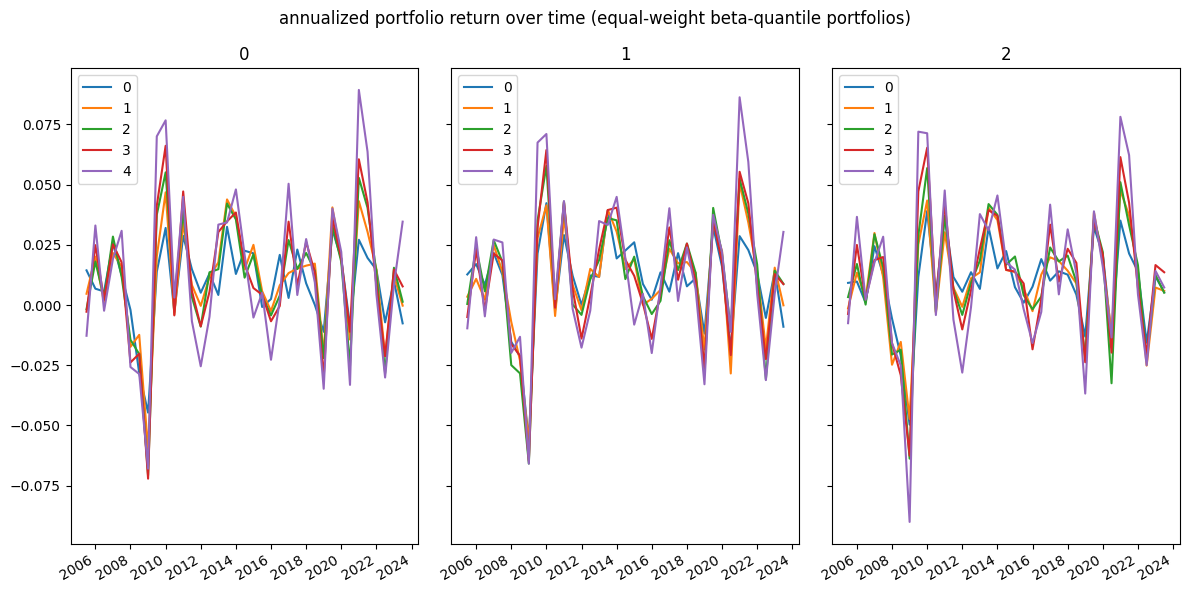

In [174]:
fig, ax = plt.subplots(1, 3, figsize=(12, 6), sharey=True)

for i in range(len(history)):
    for j in range(len(history[0])):
        sns.lineplot(x=dates, y=history[i][j], ax=ax[i], label=str(j))
    
    ax[i].set_title(str(i))

fig.autofmt_xdate()
plt.suptitle('annualized portfolio return over time (equal-weight beta-quantile portfolios)')
plt.tight_layout(); plt.show()

## Descriptive statistics over annual portfolio returns.

In [175]:

# Initialize a dictionary to store the summary statistics for each portfolio
summary_statistics = {
    'Portfolio': [],
    'Ending Value of 1USD': [],
    'Geometric Average %': [],
    'Arithmetic Average %': [],
    'Standard Deviation %': [],
    'Tracking Error %': []
}

# Calculate summary statistics for each quantile portfolio
for i in range(len(history)):  # For each type of beta
    for j in range(len(history[0])):  # For each quantile
        # Convert to a numpy array for calculation
        portfolio_returns = np.array(history[i][j])
        
        # Ending value of 1USD invested at the beginning of the period
        ending_value = np.prod(1 + portfolio_returns)
        
        # Geometric average return
        geom_avg_return = (ending_value ** (1 / len(portfolio_returns))) - 1
        
        # Arithmetic average return
        arith_avg_return = np.mean(portfolio_returns)
        
        # Standard deviation
        std_dev = np.std(portfolio_returns)
        
        # Tracking error (placeholder for now)
        tracking_error = np.nan  # Replace with actual calculation when benchmark data is available
        
        # Annualize the statistics
        geom_avg_return_annualized = ((1 + geom_avg_return) ** ANN_FACTOR) - 1
        arith_avg_return_annualized = arith_avg_return * ANN_FACTOR
        std_dev_annualized = std_dev * np.sqrt(ANN_FACTOR)
        
        # Append the statistics to the summary
        summary_statistics['Portfolio'].append(f"{['U', 'D', 'UMD'][i]}{j+1}")
        summary_statistics['Ending Value of 1USD'].append(ending_value)
        summary_statistics['Geometric Average %'].append(geom_avg_return_annualized * 100)
        summary_statistics['Arithmetic Average %'].append(arith_avg_return_annualized * 100)
        summary_statistics['Standard Deviation %'].append(std_dev_annualized * 100)
        summary_statistics['Tracking Error %'].append(tracking_error)  # Placeholder value

# Convert the summary statistics dictionary to a DataFrame
summary_stats_df = pd.DataFrame(summary_statistics)

# Append placeholders for benchmarks
benchmarks = pd.DataFrame({
    'Portfolio': ['Benchmark (U)', 'Benchmark (D)', 'Benchmark (UMD)', 'S&P'],
    'Ending Value of 1USD': [np.nan, np.nan, np.nan, np.nan],
    'Geometric Average %': [np.nan, np.nan, np.nan, np.nan],
    'Arithmetic Average %': [np.nan, np.nan, np.nan, np.nan],
    'Standard Deviation %': [np.nan, np.nan, np.nan, np.nan],
    'Tracking Error %': ['n/a', 'n/a', 'n/a', 'n/a']
})

summary_stats_table = pd.concat([summary_stats_df, benchmarks], ignore_index=True)

summary_stats_table

,Portfolio,Ending Value of 1USD,Geometric Average %,Arithmetic Average %,Standard Deviation %,Tracking Error %
0,U1,1.385987,4.509706,4.496400,3.625333,NaN
1,U2,1.485298,5.491641,5.486292,4.716901,NaN
2,U3,1.473356,5.376625,5.417183,5.514492,NaN
3,U4,1.524736,5.865887,5.909576,5.947599,NaN
4,U5,1.569610,6.281662,6.421006,7.687214,NaN
5,D1,1.431265,4.964694,4.954454,4.123477,NaN
6,D2,1.466503,5.310258,5.313847,4.748327,NaN
7,D3,1.506345,5.692421,5.723038,5.579148,NaN
8,D4,1.476683,5.408752,5.455822,5.672802,NaN
9,D5,1.597933,6.538824,6.614427,6.979742,NaN


In [176]:
RISK_FREE_RATE = .001

# Convert your accumulated history of returns into an array for calculations
# Assuming 'history' is a list of lists containing returns for each portfolio
performance_metrics = []

for i, betas in enumerate(['Low β', 'Mid β', 'High β']):
    for j, quantile in enumerate(['Q1', 'Q2', 'Q3', 'Q4', 'Q5']):
        portfolio_returns = np.array(history[i][j])
        portfolio_beta = np.mean([np.mean(beta) for beta in history[i]])  # Placeholder
        benchmark_return = 0.05 / ANN_FACTOR  # Placeholder for weekly benchmark return

        excess_returns = portfolio_returns - RISK_FREE_RATE
        
        sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns)
        treynor_ratio = np.mean(excess_returns) / portfolio_beta

        # Placeholder for alpha calculation 
        alpha = np.nan  # Placeholder

        # Information Ratio calculation would require tracking error
        information_ratio = np.nan  # Placeholder

        # VaR and ES (at 95% confidence level)
        var = np.percentile(portfolio_returns, 5)
        es = portfolio_returns[portfolio_returns <= var].mean()

        # Add the metrics to the list
        performance_metrics.append({
            'Portfolio': f'{betas} {quantile}',
            'Sharpe Ratio': sharpe_ratio,
            'Treynor Ratio': treynor_ratio,
            'Alpha %': alpha,
            'Information Ratio': information_ratio,
            'Weekly VaR(5%)': var * 100,  # Convert to percentage
            'Weekly ES(5%)': es * 100  # Convert to percentage
        })

performance_df = pd.DataFrame(performance_metrics)

performance_df


,Portfolio,Sharpe Ratio,Treynor Ratio,Alpha %,Information Ratio,Weekly VaR(5%),Weekly ES(5%)
0,Low β Q1,0.492988,0.720580,NaN,NaN,-1.457231,-3.651429
1,Low β Q2,0.472755,0.899064,NaN,NaN,-2.057860,-4.054757
2,Low β Q3,0.398773,0.886603,NaN,NaN,-2.589333,-4.955154
3,Low β Q4,0.406758,0.975385,NaN,NaN,-2.514499,-5.120969
4,Low β Q5,0.344462,1.067600,NaN,NaN,-3.347987,-5.135356
5,Mid β Q1,0.483110,0.793692,NaN,NaN,-1.901279,-3.885958
6,Mid β Q2,0.453385,0.857729,NaN,NaN,-2.414043,-4.277426
7,Mid β Q3,0.418669,0.930638,NaN,NaN,-2.925034,-4.835230
8,Mid β Q4,0.390691,0.883026,NaN,NaN,-2.312778,-4.533276
9,Mid β Q5,0.391770,1.089466,NaN,NaN,-3.151628,-4.938170


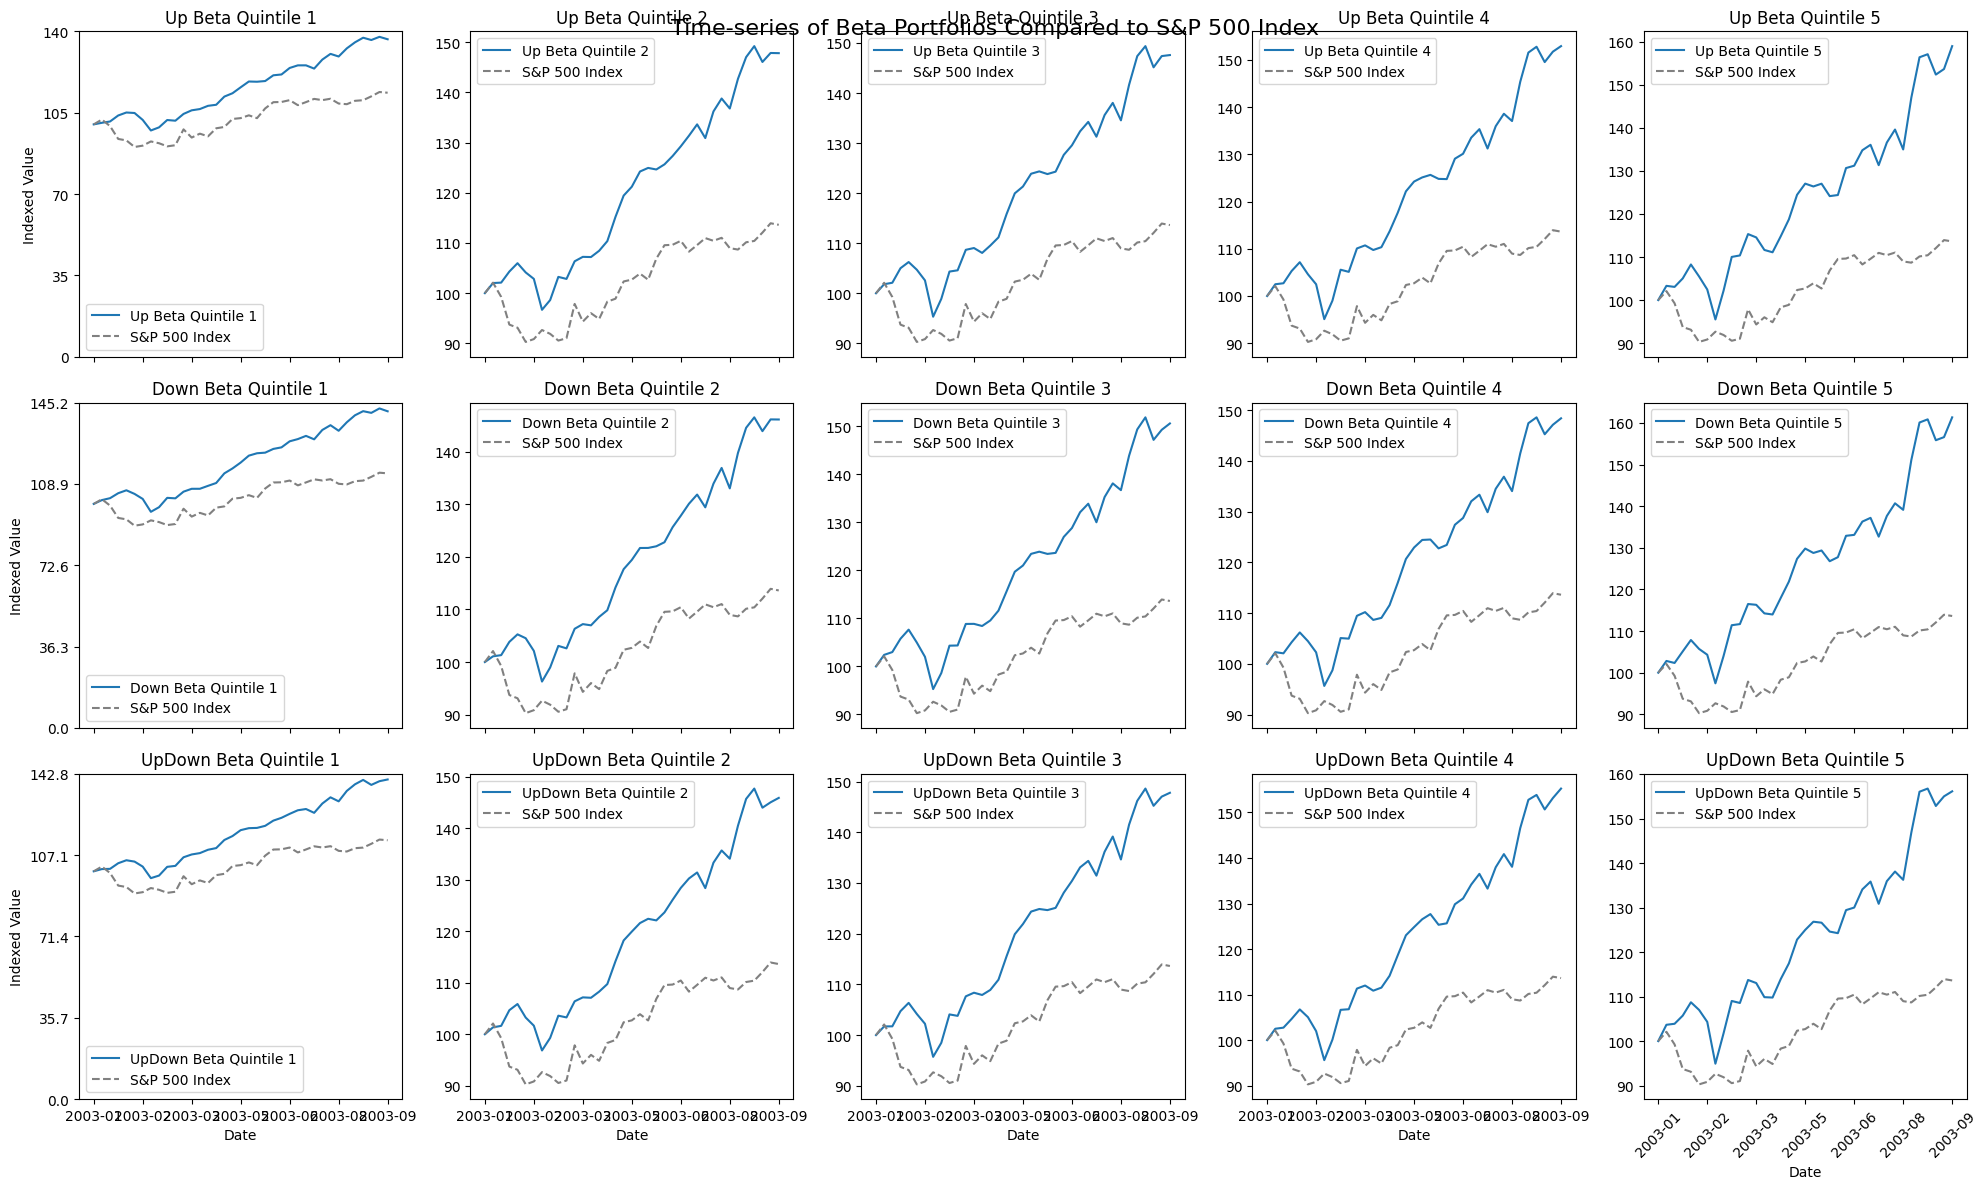

In [177]:

cumulative_history = [
    [np.cumprod(1 + np.array(returns)) for returns in beta_group]
    for beta_group in history
]

# dates list must correspond to the dates of the returns in history
dates = pd.date_range(start=stocks.date.min(), periods=len(history[0][0]), freq='W')


# Normalize and prepare the cumulative returns for plotting
cumulative_returns = {
    'Up': [],
    'Down': [],
    'UpDown': []
}

# Calculate cumulative returns and normalize to start at 100
for beta_type, returns_group in zip(cumulative_returns.keys(), history):
    for returns in returns_group:
        cumulative = np.cumprod(1 + np.array(returns))  # Convert weekly returns to cumulative
        indexed = 100 * cumulative / cumulative[0]      # Normalize to start at 100
        cumulative_returns[beta_type].append(indexed)

sp500_indexed_trimmed = market.loc[dates]

sp500_cumulative = (1 + sp500_indexed_trimmed['sprtrn']).cumprod()

sp500_indexed = 100 * sp500_cumulative / sp500_cumulative.iloc[0]  # Normalize to start at 100

# plot the time-series for each beta category
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 12), sharex=True)

beta_categories = ['Up', 'Down', 'UpDown']
for i, beta_category in enumerate(beta_categories):
    for j in range(5):
        ax = axes[i][j]
        ax.plot(dates, cumulative_returns[beta_category][j], label=f'{beta_category} Beta Quintile {j+1}')
        ax.plot(dates, sp500_indexed, label='S&P 500 Index', color='grey', linestyle='--')
        ax.set_title(f'{beta_category} Beta Quintile {j+1}')
        ax.legend()

# Set common labels and titles
for ax in axes[-1]:
    ax.set_xlabel('Date')
for i, ax in enumerate(axes[:, 0]):
    ax.set_ylabel('Indexed Value')
    ax.set_yticks(np.linspace(0, ax.get_ylim()[1], 5))

# Set the x-axis to show specific dates for clarity
plt.setp(axes, xticks=dates[::len(dates) // 6], xticklabels=[d.strftime('%Y-%m') for d in dates[::len(dates) // 6]])

# Rotate date labels and adjust layout (dont know why i cant fix the others (only last one rotates))
plt.xticks(rotation=45)
plt.tight_layout()
plt.suptitle('Time-series of Beta Portfolios Compared to S&P 500 Index', fontsize=16)
plt.show()


In [178]:
raise ValueError

ValueError: 

In [ ]:
# The portfolios were evaluated in three steps. First, to evaluate each portfolio’s relative
# performance, a benchmark index consisting of all eligible stocks, the same rebalancing date,
# and weighting technique as the quintile portfolio had to be constructed. However, since positive
# and negative observations of the market return are required to estimate both the upside- and
# downside beta of a stock using OLS, the composition of stocks for each benchmark will differ
# at some point in time.
# ??!?!?!?!?!?!?!?

In [ ]:
# Convert 'date' to datetime
sp500_constituents['date'] = pd.to_datetime(sp500_constituents['date'])

# Set date as the index
sp500_constituents.set_index('date', inplace=True)

sp500_constituents['ending'] = pd.to_datetime(sp500_constituents['ending'])

# classify the stock as listed or delisted based on whether 'date' is before 'ending'
sp500_constituents['Status'] = np.where(sp500_constituents.index < sp500_constituents['ending'], 'Listed', 'Delisted')

#filter
listed_stocks = sp500_constituents[sp500_constituents['Status'] == 'Listed']
delisted_stocks = sp500_constituents[sp500_constituents['Status'] == 'Delisted']

In [ ]:
#Group by 'permno' and 'Status', and resample to weekly while compounding returns
sp500_constituents_weekly = sp500_constituents.groupby(['permno', 'Status'])['ret'].resample('W').apply(lambda x: (1 + x).prod() - 1)

sp500_constituents_weekly = sp500_constituents_weekly.reset_index()

sp500_index['date'] = pd.to_datetime(sp500_index['caldt'])
sp500_index.set_index('date', inplace=True)
sp500_index['sprtrn'] = sp500_index['sprtrn'].astype(float)
sp500_index_weekly = sp500_index['sprtrn'].resample('W').apply(lambda x: (1 + x).prod() - 1)
sp500_index_weekly = sp500_index_weekly.reset_index()
sp500_index_weekly.rename(columns={'sprtrn': 'ret_market'}, inplace=True)


In [ ]:
sp500_constituents_weekly

,permno,Status,date,ret
0,10078,Listed,2003-01-05,0.141480
1,10078,Listed,2003-01-12,0.061972
2,10078,Listed,2003-01-19,-0.005040
3,10078,Listed,2003-01-26,-0.079178
4,10078,Listed,2003-02-02,-0.105386
...,...,...,...,...
518087,93436,Listed,2023-12-03,0.014356
518088,93436,Listed,2023-12-10,0.020978
518089,93436,Listed,2023-12-17,0.039617
518090,93436,Listed,2023-12-24,-0.003787


In [ ]:
#Descriptive Statistics
def calculate_descriptive_stats(data):
    return {
        'Number of Indices': len(data),
        'Average Return': data.mean(),
        'Standard Deviation': data.std(),
        'Skewness': data.skew(),
        'Kurtosis': data.kurtosis()
    }

listed_stats = calculate_descriptive_stats(sp500_constituents_weekly[sp500_constituents_weekly['Status'] == 'Listed'].ret)
delisted_stats = calculate_descriptive_stats(sp500_constituents_weekly[sp500_constituents_weekly['Status'] == 'Delisted'].ret)
all_stocks_stats = calculate_descriptive_stats(sp500_constituents_weekly.ret)
sp500_index_stats = calculate_descriptive_stats(sp500_index_weekly.ret_market)

# descriptive statistics in a table format
stats_table = pd.DataFrame({
    'Listed Stocks': listed_stats,
    'Delisted Stocks': delisted_stats,
    'All Stocks': all_stocks_stats,
    'S&P 500 Index': sp500_index_stats,
})
print(stats_table)

                    Listed Stocks  Delisted Stocks     All Stocks  \
Number of Indices   511176.000000      6916.000000  518092.000000   
Average Return           0.002562        -0.000760       0.002518   
Standard Deviation       0.048079         0.015499       0.047792   
Skewness                 0.665961       -19.957591       0.662380   
Kurtosis                25.751609       911.153321      26.195005   

                    S&P 500 Index  
Number of Indices     3209.000000  
Average Return           0.001631  
Standard Deviation       0.022020  
Skewness                -0.374274  
Kurtosis                 5.259521  


# Empirical Model

In [ ]:
#Exclude stocks with less than two years of history
two_years = pd.Timedelta(weeks=104)
valid_stocks = sp500_constituents_weekly.groupby('permno').filter(lambda x: (x['date'].max() - x['date'].min()) >= two_years)
valid_stocks.index = valid_stocks.date
valid_stocks

,permno,Status,date,ret
date,,,,
2003-01-05,10078,Listed,2003-01-05,0.141480
2003-01-12,10078,Listed,2003-01-12,0.061972
2003-01-19,10078,Listed,2003-01-19,-0.005040
2003-01-26,10078,Listed,2003-01-26,-0.079178
2003-02-02,10078,Listed,2003-02-02,-0.105386
...,...,...,...,...
2023-12-03,93436,Listed,2023-12-03,0.014356
2023-12-10,93436,Listed,2023-12-10,0.020978
2023-12-17,93436,Listed,2023-12-17,0.039617


In [ ]:
sp500_index_weekly

,date,ret_market
0,1962-07-08,0.005549
1,1962-07-15,0.029554
2,1962-07-22,-0.017638
3,1962-07-29,0.006865
4,1962-08-05,0.016085
...,...,...
3204,2023-12-03,0.007741
3205,2023-12-10,0.002120
3206,2023-12-17,0.024938
3207,2023-12-24,0.007510


In [ ]:
# Ensure dates are aligned and set as indices
sp500_constituents_weekly.set_index(['date', 'permno'], inplace=True)
sp500_index_weekly.set_index('date', inplace=True)

# Merge the stock returns with market returns on date
combined = sp500_constituents_weekly.join(sp500_index_weekly, how='inner')
combined.reset_index(inplace=True)  # Reset index to keep 'date' and 'permno' as columns


In [ ]:
# Filter out stocks not listed for a full two-year period and those delisted within the next six months
min_history_date = combined.groupby('permno')['date'].transform(min) + pd.DateOffset(years=2)
delisting_date = combined.groupby('permno')['date'].transform(max) - pd.DateOffset(months=6)
combined = combined[(combined['date'] >= min_history_date) & (combined['date'] < delisting_date)]


/var/folders/l3/4qywm6wn4273cj1z5n54pm_h0000gn/T/ipykernel_5208/44432538.py:2: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  min_history_date = combined.groupby('permno')['date'].transform(min) + pd.DateOffset(years=2)
/var/folders/l3/4qywm6wn4273cj1z5n54pm_h0000gn/T/ipykernel_5208/44432538.py:3: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  delisting_date = combined.groupby('permno')['date'].transform(max) - pd.DateOffset(months=6)


In [ ]:
combined = combined[["date", "permno", "ret", "ret_market"]]
#combined.set_index(['date', 'permno'], inplace=True)

## Estimate rolling betas

In [ ]:
# regular, upside, downside
# 2 year rolling, slide 6 mo. every increment for realized return
# sort by 20%iles

In [ ]:
def calculate_rolling_beta(combined, window_size):

    
    # Calculate rolling covariance and variance
    rolling_cov = combined['ret'].rolling(window=window_size).cov(combined['ret_market'])
    rolling_var = combined['ret_market'].rolling(window=window_size).var()
    
    # Calculate rolling beta
    rolling_beta = rolling_cov / rolling_var
    
    return rolling_beta

In [ ]:
window_size = 104  # Two years of weekly data
combined['beta'] = calculate_rolling_beta(combined, window_size)
combined

,date,permno,ret,ret_market,beta
105,2005-01-09,10078,-0.142858,-0.021230,NaN
106,2005-01-16,10078,-0.086581,-0.001408,NaN
107,2005-01-23,10078,-0.011847,-0.014056,NaN
108,2005-01-30,10078,0.021583,0.002988,NaN
109,2005-02-06,10078,0.014085,0.027036,NaN
...,...,...,...,...,...
518060,2023-05-28,93436,0.072333,0.003213,1.941282
518061,2023-06-04,93436,0.107677,0.018290,1.986202
518062,2023-06-11,93436,0.142217,0.003851,1.997397
518063,2023-06-18,93436,0.066040,0.025757,2.018366


In [ ]:
def calculate_up_down_betas(combined, window_size):
    # Separate returns based on market performance
    up_market = combined[combined['ret_market'] > 0]
    down_market = combined[combined['ret_market'] <= 0]

    # Calculate rolling covariance and variance for up markets
    rolling_cov_up = up_market['ret'].rolling(window=window_size).cov(up_market['ret_market'])
    rolling_var_up = up_market['ret_market'].rolling(window=window_size).var()

    # Calculate rolling covariance and variance for down markets
    rolling_cov_down = down_market['ret'].rolling(window=window_size).cov(down_market['ret_market'])
    rolling_var_down = down_market['ret_market'].rolling(window=window_size).var()

    # Calculate rolling betas for up and down markets
    beta_up = rolling_cov_up / rolling_var_up
    beta_down = rolling_cov_down / rolling_var_down

    return beta_up, beta_down

combined['beta_up'], combined['beta_down'] = calculate_up_down_betas(combined, window_size)


In [ ]:
combined

,date,permno,ret,ret_market,beta,beta_up,beta_down
105,2005-01-09,10078,-0.142858,-0.021230,NaN,NaN,NaN
106,2005-01-16,10078,-0.086581,-0.001408,NaN,NaN,NaN
107,2005-01-23,10078,-0.011847,-0.014056,NaN,NaN,NaN
108,2005-01-30,10078,0.021583,0.002988,NaN,NaN,NaN
109,2005-02-06,10078,0.014085,0.027036,NaN,NaN,NaN
...,...,...,...,...,...,...,...
518060,2023-05-28,93436,0.072333,0.003213,1.941282,2.124437,NaN
518061,2023-06-04,93436,0.107677,0.018290,1.986202,2.172337,NaN
518062,2023-06-11,93436,0.142217,0.003851,1.997397,1.997228,NaN
518063,2023-06-18,93436,0.066040,0.025757,2.018366,2.250077,NaN


In [ ]:
def form_quintile_portfolios(combined, beta_column_name):
    # Group by 'date' column and calculate quintiles
    quintiles = combined.groupby('date')[beta_column_name].transform(
        lambda x: pd.qcut(x.rank(method='first'), 5, labels=False, duplicates='drop')
    )

    return quintiles

combined['quintile_beta_up'] = form_quintile_portfolios(combined, 'beta_up')
combined['quintile_beta_down'] = form_quintile_portfolios(combined, 'beta_down')
#combined['quintile_beta_diff'] = form_quintile_portfolios(combined, 'beta_up') - form_quintile_portfolios(combined, 'beta_down')

In [ ]:
combined

,date,permno,ret,ret_market,beta,beta_up,beta_down,quintile_beta_up,quintile_beta_down
105,2005-01-09,10078,-0.142858,-0.021230,NaN,NaN,NaN,NaN,NaN
106,2005-01-16,10078,-0.086581,-0.001408,NaN,NaN,NaN,NaN,NaN
107,2005-01-23,10078,-0.011847,-0.014056,NaN,NaN,NaN,NaN,NaN
108,2005-01-30,10078,0.021583,0.002988,NaN,NaN,NaN,NaN,NaN
109,2005-02-06,10078,0.014085,0.027036,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
518060,2023-05-28,93436,0.072333,0.003213,1.941282,2.124437,NaN,4.0,NaN
518061,2023-06-04,93436,0.107677,0.018290,1.986202,2.172337,NaN,4.0,NaN
518062,2023-06-11,93436,0.142217,0.003851,1.997397,1.997228,NaN,4.0,NaN
518063,2023-06-18,93436,0.066040,0.025757,2.018366,2.250077,NaN,4.0,NaN


In [ ]:
def portfolio_returns(combined, quintile_column):
    portfolio_returns = combined.groupby(['date', quintile_column])['ret'].mean()
    return portfolio_returns

returns_beta_up = portfolio_returns(combined, 'quintile_beta_up')
returns_beta_down = portfolio_returns(combined, 'quintile_beta_down')
#returns_beta_diff = portfolio_returns(combined, 'quintile_beta_diff')


In [ ]:
def calculate_performance_metrics(portfolio_returns):
    avg_return = portfolio_returns.mean()
    std_dev = portfolio_returns.std()
    sharpe_ratio = avg_return / std_dev
    return {'Average Return': avg_return, 'Standard Deviation': std_dev, 'Sharpe Ratio': sharpe_ratio}

performance_up = calculate_performance_metrics(returns_beta_up)
performance_down = calculate_performance_metrics(returns_beta_down)
#performance_diff = calculate_performance_metrics(returns_beta_diff)

# Display the performance metrics for each portfolio
print(f"Performance up: {performance_up}")
print(f"Performance down: {performance_down}")
#print(f"Performanc diff: {performance_diff}")


Performance up: {'Average Return': 0.018013747069521295, 'Standard Deviation': 0.02403122937477029, 'Sharpe Ratio': 0.7495974004739608}
Performance down: {'Average Return': -0.018405053917167916, 'Standard Deviation': 0.025730732634039855, 'Sharpe Ratio': -0.7152945926156565}


In [ ]:
def portfolio_returns(combined, quintile_column):
    # Calculate average returns for each portfolio formed on quintiles
    portfolio_returns = combined.groupby(['date', quintile_column])['ret'].mean().unstack()
    return portfolio_returns

# Calculate portfolio returns based on beta quintiles
returns_beta_up = portfolio_returns(combined, 'quintile_beta_up')
returns_beta_down = portfolio_returns(combined, 'quintile_beta_down')
#returns_beta_diff = portfolio_returns(combined, 'quintile_beta_diff')


# Results

In [ ]:
def calculate_descriptive_stats(portfolio_return):
    """Calculate various descriptive statistics for each portfolio."""
    geometric_mean = np.exp(np.mean(np.log1p(portfolio_return))) - 1  # Annualized geometric mean
    arithmetic_mean = portfolio_return.mean() * 52  # Convert weekly to annual
    std_dev = portfolio_return.std() * np.sqrt(52)  # Annualize standard deviation
    sharpe_ratio = arithmetic_mean / std_dev
    return {
        'Ending Value': (1 + portfolio_return).cumprod().iloc[-1],
        'Geometric Mean': geometric_mean,
        'Arithmetic Mean': arithmetic_mean,
        'Standard Deviation': std_dev,
        'Sharpe Ratio': sharpe_ratio
    }

stats_beta_up = {col: calculate_descriptive_stats(returns_beta_up[col]) for col in returns_beta_up.columns}
stats_table_up = pd.DataFrame(stats_beta_up).T
print(stats_table_up)

stats_beta_down = {col: calculate_descriptive_stats(returns_beta_down[col]) for col in returns_beta_down.columns}
stats_table_down = pd.DataFrame(stats_beta_down).T
print(stats_table_down)

# stats_beta_diff = {col: calculate_descriptive_stats(returns_beta_diff[col]) for col in returns_beta_diff.columns}
# stats_table_diff = pd.DataFrame(stats_beta_diff).T
# print(stats_table_diff)


      Ending Value  Geometric Mean  Arithmetic Mean  Standard Deviation  \
0.0     416.184401        0.011046         0.576866            0.070780   
1.0    5356.286934        0.015762         0.824891            0.104323   
2.0   14895.468956        0.017656         0.926842            0.135283   
3.0   60019.214238        0.020243         1.066661            0.173347   
4.0  473672.356460        0.024089         1.288314            0.284044   

     Sharpe Ratio  
0.0      8.150099  
1.0      7.907075  
2.0      6.851122  
3.0      6.153346  
4.0      4.535617  
     Ending Value  Geometric Mean  Arithmetic Mean  Standard Deviation  \
0.0      0.011671       -0.010667        -0.550632            0.089153   
1.0      0.001130       -0.016217        -0.834757            0.127680   
2.0      0.000488       -0.018208        -0.933888            0.155972   
3.0      0.000104       -0.021852        -1.114760            0.199868   
4.0      0.000013       -0.026821        -1.351277         

In [ ]:
# Assuming 'combined' DataFrame from your setup with 'quintile_beta_up' column already created
combined['weights'] = 1 / combined.groupby(['date', 'quintile_beta_up'])['permno'].transform('count')  # Equal weights

# Calculate weighted returns
combined['weighted_returns'] = combined['ret'] * combined['weights']

# Function to perform backtest
def backtest_portfolio(portfolio_returns):
    cumulative_returns = (1 + portfolio_returns).cumprod()
    cagr = cumulative_returns.iloc[-1] ** (52 / len(cumulative_returns)) - 1  # Compounded Annual Growth Rate
    max_drawdown = (cumulative_returns.cummax() - cumulative_returns).max()
    vol = portfolio_returns.std() * np.sqrt(52)  # Annualized volatility
    sharpe_ratio = cagr / vol
    return {
        'CAGR': cagr,
        'Max Drawdown': max_drawdown,
        'Volatility': vol,
        'Sharpe Ratio': sharpe_ratio
    }

# Aggregate portfolio returns by date
portfolio_returns = combined.groupby(['date', 'quintile_beta_up'])['weighted_returns'].sum()

# Reshape data to have quintile columns
portfolio_returns = portfolio_returns.unstack(level='quintile_beta_up')

# Backtest each quintile portfolio
backtest_results = {f'Quintile {i+1}': backtest_portfolio(portfolio_returns[i]) for i in range(5)}
backtest_results_df = pd.DataFrame(backtest_results).T
print(backtest_results_df)


                CAGR  Max Drawdown  Volatility  Sharpe Ratio
Quintile 1  0.770487      8.756046    0.070780     10.885617
Quintile 2  1.255222     85.090544    0.104323     12.032054
Quintile 3  1.484631    164.490660    0.135283     10.974247
Quintile 4  1.835231    742.018181    0.173347     10.587068
Quintile 5  2.448006  19246.700743    0.284044      8.618410


In [ ]:
combined

,date,permno,ret,ret_market,beta,beta_up,beta_down,quintile_beta_up,quintile_beta_down,weights,weighted_returns
105,2005-01-09,10078,-0.142858,-0.021230,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106,2005-01-16,10078,-0.086581,-0.001408,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107,2005-01-23,10078,-0.011847,-0.014056,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,2005-01-30,10078,0.021583,0.002988,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,2005-02-06,10078,0.014085,0.027036,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
518060,2023-05-28,93436,0.072333,0.003213,1.941282,2.124437,NaN,4.0,NaN,0.011628,0.000841
518061,2023-06-04,93436,0.107677,0.018290,1.986202,2.172337,NaN,4.0,NaN,0.011628,0.001252
518062,2023-06-11,93436,0.142217,0.003851,1.997397,1.997228,NaN,4.0,NaN,0.011628,0.001654
518063,2023-06-18,93436,0.066040,0.025757,2.018366,2.250077,NaN,4.0,NaN,0.011628,0.000768


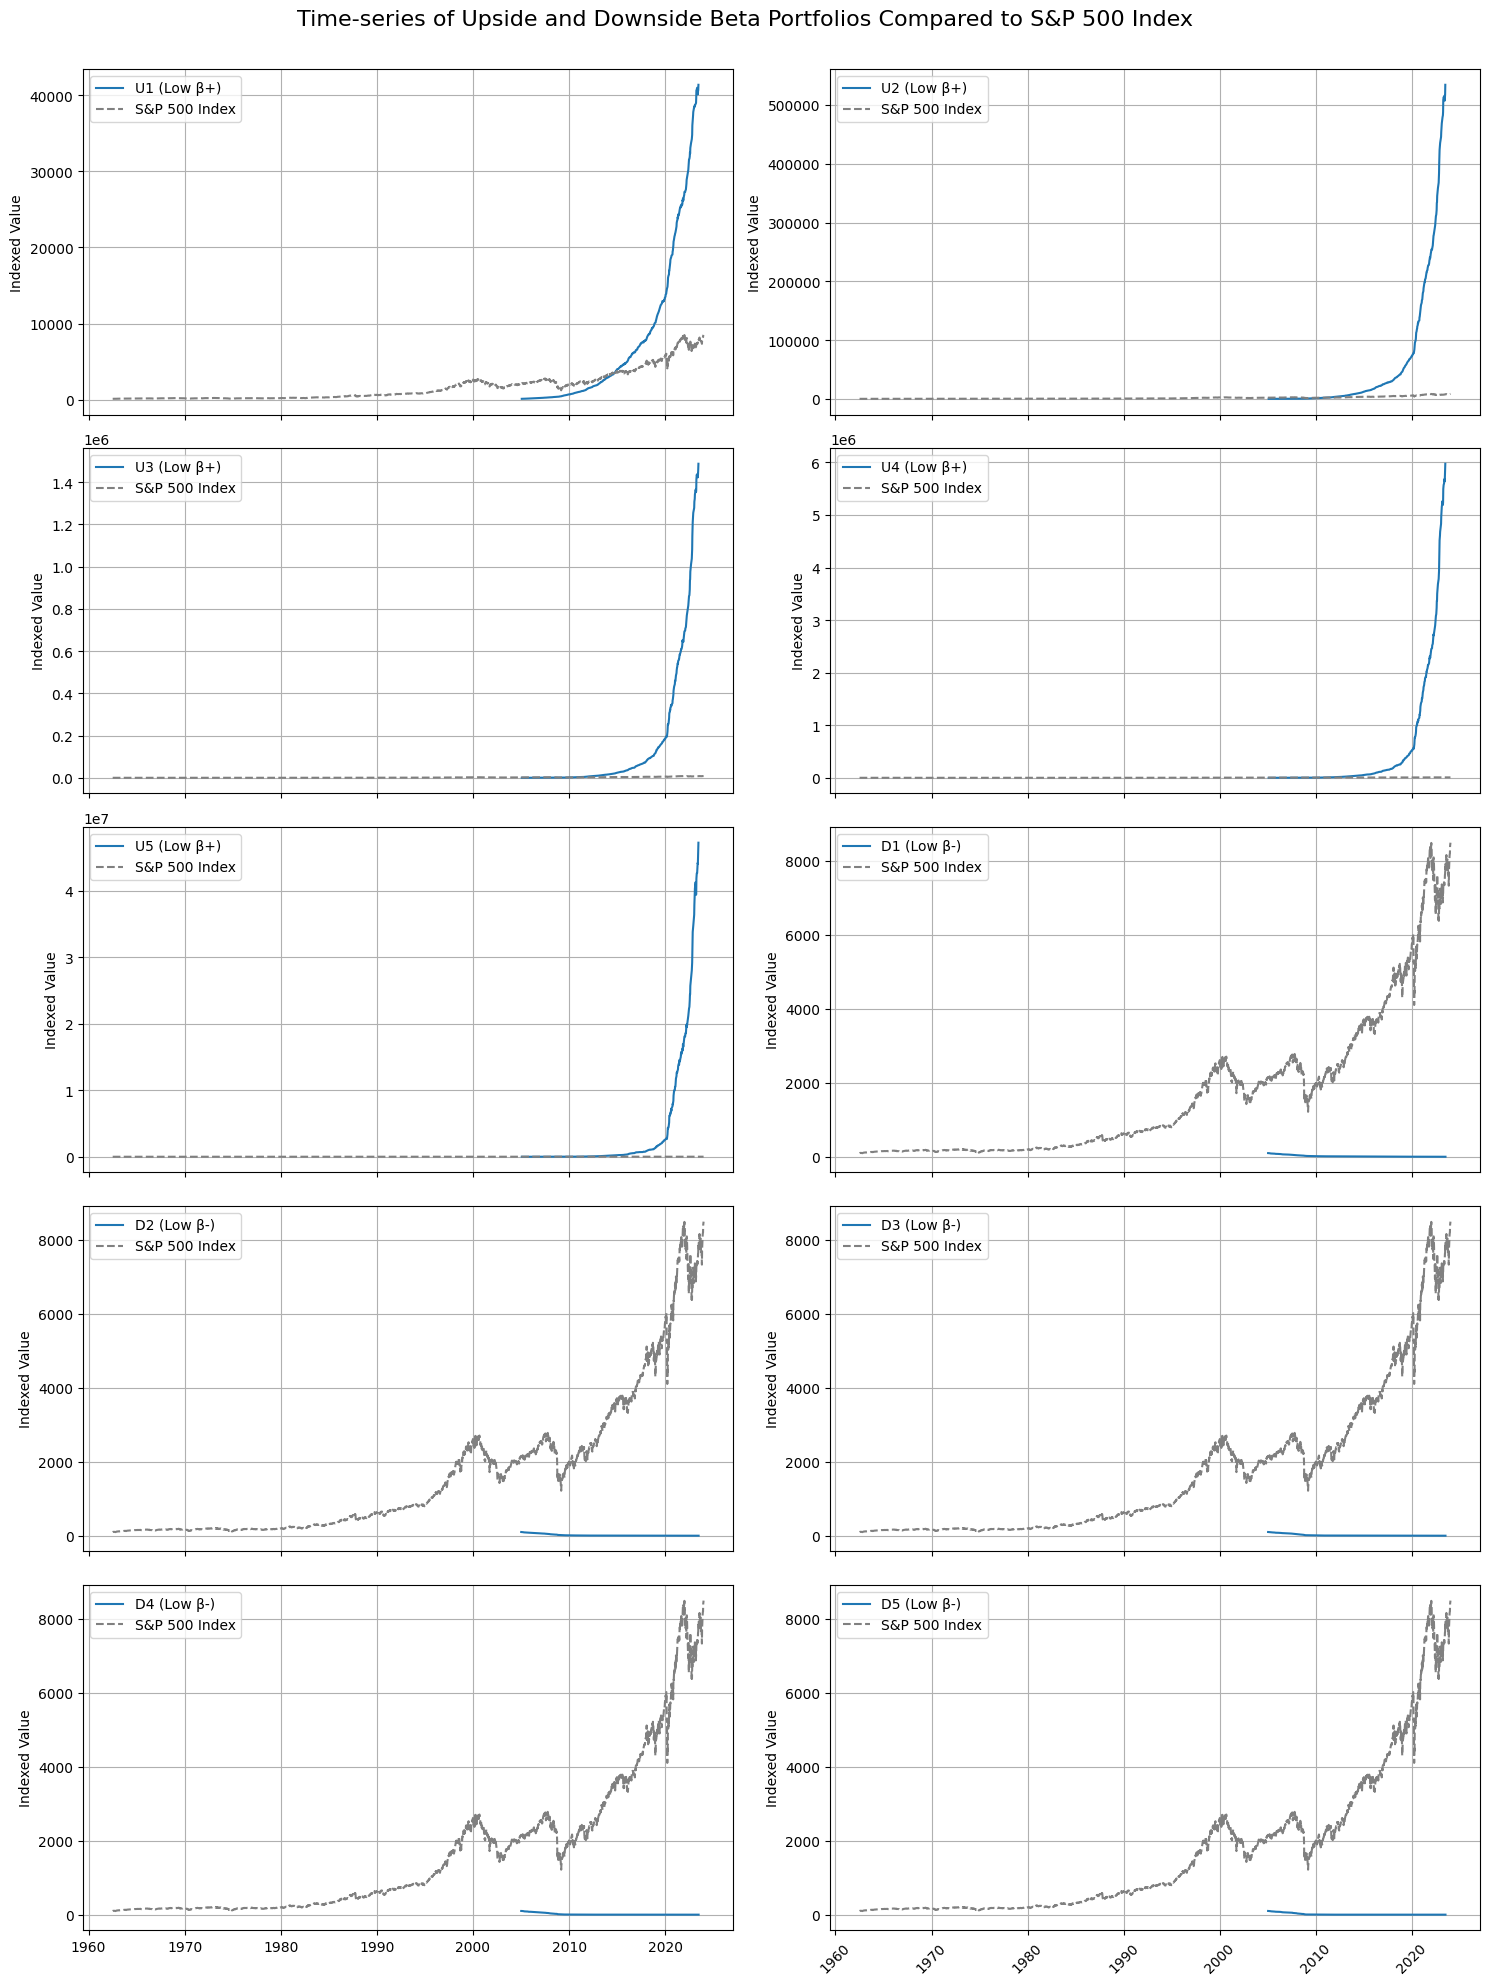

In [ ]:
# Calculate cumulative returns for the S&P 500 Index
sp500_index_weekly['cumulative'] = (1 + sp500_index_weekly['ret_market']).cumprod()

# Normalize the starting point to 100 for comparison
sp500_index_weekly['indexed'] = 100 * sp500_index_weekly['cumulative'] / sp500_index_weekly['cumulative'].iloc[0]

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20), sharex=True)

# Iterate over quintiles and plot each one
for i, ax in enumerate(axes.flatten()):
    quintile_label = f'Quintile {i+1}'
    
    # Check if we're dealing with an 'up' or 'down' plot
    if i < 5:
        ax.plot(cumulative_returns_up.index, cumulative_returns_up[i], label=f'U{i+1} (Low β+)')
    else:
        ax.plot(cumulative_returns_down.index, cumulative_returns_down[i-5], label=f'D{i-4} (Low β-)')
    
    # Plot the S&P 500 Index on each subplot for reference
    ax.plot(sp500_index_weekly.index, sp500_index_weekly['indexed'], label='S&P 500 Index', color='grey', linestyle='--')
    
    # Add labels, legend, and make sure grid is on for better readability
    ax.set_ylabel('Indexed Value')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.xticks(rotation=45)
plt.subplots_adjust(top=0.95)
plt.suptitle('Time-series of Upside and Downside Beta Portfolios Compared to S&P 500 Index', fontsize=16)
plt.show()
